In [1]:
import numpy as np
import pandas as pd
from functools import reduce

In [2]:
_MULTIINDEX_ = ["NOMBREDD", "NOMBREPV", "NOMBREDI", "CONGLOMERADO", "NSELUA", "UA"]

In [3]:
_UACROP_ = ["NOMBREDD", "NOMBREPV", "NOMBREDI", "CONGLOMERADO", "NSELUA", "UA", "crop"]

In [4]:
_CROPNAME_ = "PAPA BLANCA"

In [5]:
_PATH_ = "https://public.minsky.cc/maria/market_channel_factors_db"

In [6]:
df = pd.read_csv(_PATH_ + "/" + "databases/2019_02DatabaseFilteredByWhitePotato.csv")

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,19,37,46,49,50,51,52,57,79,81,85,87,93,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,127,129,131,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,184,189,194,195,196,197,198,201,202,203,204,205,206,207,208,209,210,214,216,227,239,240,241,242,243,244,245,246,248,249,251,252,254,255,257,258,260,261,263,264,266,267,269,270,272,273,275,276,278,279,281,282,284,285,287,288,290,291,293,294,296,297,299,300,302,303,305,306,308,309,311,314,315,317,321,322,324,325,327,328,330,331,333,334,336,339,340,342,343,345,346,348,349,351,352,354,355,357,358,360,361,363,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,4

In [7]:
df = df.drop(columns=["Unnamed: 0"])

In [8]:
df.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'cropsList', 'crops', 'ANIO', 'CCDD',
       ...
       'P712_9', 'P713_1', 'P713_2', 'P713_3', 'P713_4', 'P713_5', 'P713_6',
       'P713_7', 'P713_8', 'OMICAP700'],
      dtype='object', length=538)

In [9]:
def getVariable_UA_Crops(df, variable):
    df_UA_CROPS = df.groupby(_UACROP_)[variable].unique().apply(lambda x: np.sum(x)).reset_index()
    return df_UA_CROPS

# Productivity

In [10]:
def getProduction(df):
    df["production"] = (df["P219_CANT_1"] + df["P219_CANT_2"].apply(pd.to_numeric, errors="coerce")/1000) * df["P219_EQUIV_KG"]

def getTotalProduction_UA(df_UA_CROPS):
    df_total_UA = df_UA_CROPS.groupby(_MULTIINDEX_)["production"].apply(np.sum).reset_index()
    return df_total_UA.rename(columns={"production": "totalProduction"})

def getPercentageCropProduction_UA(df, cropName):
    getProduction(df)
    df_UA_CROPS = getVariable_UA_Crops(df, "production")
    df_total = getTotalProduction_UA(df_UA_CROPS)
    df_crop = df_UA_CROPS[df_UA_CROPS["crop"] == cropName].reset_index(drop=True)
    df_concat = pd.concat([df_crop, df_total["totalProduction"]], axis=1, sort=False)
    df_concat["percentProduction"] = df_concat["production"] / df_concat["totalProduction"]
    return df_concat

def getProduction_Sold(df):
    df["soldProduction"] = (df["P220_1_CANT_1"] + df["P220_1_CANT_2"].apply(pd.to_numeric, errors="coerce") / 1000) * df["P219_EQUIV_KG"]

def getTotalProductionSold_UA(df_UA_CROPS):
    df_total_UA = df_UA_CROPS.groupby(_MULTIINDEX_)["soldProduction"].apply(np.sum).reset_index()
    return df_total_UA.rename(columns={"soldProduction": "totalSoldProduction"})

def getPercentageCropProductionSold_UA(df, cropName):
    getProduction_Sold(df)
    df_UA_CROPS = getVariable_UA_Crops(df, "soldProduction")
    df_total = getTotalProductionSold_UA(df_UA_CROPS)
    df_crop = df_UA_CROPS[df_UA_CROPS["crop"] == cropName].reset_index(drop=True)
    df_concat = pd.concat([df_crop, df_total["totalSoldProduction"]], axis=1, sort=False)
    df_concat["percentSoldProduction"] = df_concat["soldProduction"] / df_concat["totalSoldProduction"]
    return df_concat

def getCropIncomes(df):
    df["farmGatePricePerKg"] = df["P220_1_VAL"] / df["soldProduction"]
    df["farmGateIncomes"] = df["farmGatePricePerKg"] * df["soldProduction"]

def getTotalCropIncomes_UA(df_UA_CROPS, df_UA_CROPS_kg):
    df_total_UA = df_UA_CROPS.groupby(_MULTIINDEX_)["farmGateIncomes"].apply(np.sum).reset_index()
    df_total_UA_kg = df_UA_CROPS_kg.groupby(_MULTIINDEX_)["farmGatePricePerKg"].apply(np.sum).reset_index()
    return df_total_UA.rename(columns={"farmGateIncomes": "totalFarmGateIncomes"})

def getPercentageCropIncomes_UA(df, cropName):
    getCropIncomes(df)
    getProduction_Sold(df)
    df_UA_CROPS = getVariable_UA_Crops(df, "farmGateIncomes")
    df_UA_CROPS_kg = getVariable_UA_Crops(df, "farmGatePricePerKg")
    df_total = getTotalCropIncomes_UA(df_UA_CROPS, df_UA_CROPS_kg)
    df_crop = df_UA_CROPS[df_UA_CROPS["crop"] == cropName].reset_index(drop=True)
    df_crop_kg = df_UA_CROPS_kg[df_UA_CROPS_kg["crop"] == cropName].reset_index(drop=True)
    df_concat = pd.concat([df_crop_kg, df_crop["farmGateIncomes"], df_total["totalFarmGateIncomes"]], axis=1, sort=False)
    df_concat["percentFarmGateIncomes"] = df_concat["farmGateIncomes"] / df_concat["totalFarmGateIncomes"]
    return df_concat

def getAreaSembrada(df):
    df["plantedArea"] = df["P210_SUP_1"] + (df["P210_SUP_2"].apply(pd.to_numeric, errors="coerce")/1000)

def getTotalAreaSembrada_UA(df_UA_CROPS):
    df_totalArea_UA = df_UA_CROPS.groupby(_MULTIINDEX_)["plantedArea"].apply(np.sum).reset_index()
    return df_totalArea_UA.rename(columns={"plantedArea": "totalPlantedArea"})

def getPercentageCropPlantedAreaAndYield_UA(df, cropName):
    getAreaSembrada(df)
    getProduction(df)
    df_UA_CROPS = getVariable_UA_Crops(df, "plantedArea")
    df_UA_CROPS_production = getVariable_UA_Crops(df, "production")
    df_total_area = getTotalAreaSembrada_UA(df_UA_CROPS)
    df_crop_area = df_UA_CROPS[df_UA_CROPS["crop"] == cropName].reset_index(drop=True)
    df_crop_production = df_UA_CROPS_production[df_UA_CROPS_production["crop"] == cropName].reset_index(drop=True)
    df_concat = pd.concat([df_crop_area, df_total_area["totalPlantedArea"], df_crop_production["production"]], axis=1, sort=False)
    df_concat["percentPlantedArea"] = df_concat["plantedArea"] / df_concat["totalPlantedArea"]
    df_concat["yield"] = df_concat["production"] / df_concat["plantedArea"]
    return df_concat

In [11]:
def mergeDataFrames(dfArray, indices):
    dfList = []
    for df in dfArray:
        dfList.append(df)
    df = reduce(lambda x, y: pd.merge(x, y, how="left", on = indices, suffixes=("", "_y")), dfList)
    filter = [col for col in df if col.endswith("y")]
    #Eliminar
    df_drop = df.drop(columns=filter)
    #Seleccionar
    df_keep = df[filter]
    return df_drop

In [12]:
df_production = getPercentageCropProduction_UA(df, _CROPNAME_)
df_soldProduction = getPercentageCropProductionSold_UA(df, _CROPNAME_)
df_incomes = getPercentageCropIncomes_UA(df, _CROPNAME_)
df_plantedAreaAndYield = getPercentageCropPlantedAreaAndYield_UA(df, _CROPNAME_)

In [13]:
df01 = mergeDataFrames([df_production, df_soldProduction, df_incomes, df_plantedAreaAndYield], _MULTIINDEX_)

In [14]:
#df01

In [15]:
df01.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'crop', 'production', 'totalProduction', 'percentProduction',
       'soldProduction', 'totalSoldProduction', 'percentSoldProduction',
       'farmGatePricePerKg', 'farmGateIncomes', 'totalFarmGateIncomes',
       'percentFarmGateIncomes', 'plantedArea', 'totalPlantedArea',
       'percentPlantedArea', 'yield'],
      dtype='object')

In [16]:
#df01["percentFarmGateIncomes"].hist()

In [17]:
def filteringBySoldProductionAndFarmGateIncomesMoreThanZero(df):
    new = df[df["soldProduction"] > 0].reset_index(drop=True)
    return new[new["farmGateIncomes"] > 0].reset_index(drop=True)

In [18]:
df_productivity = filteringBySoldProductionAndFarmGateIncomesMoreThanZero(df01)

In [19]:
len(df_productivity)

1949

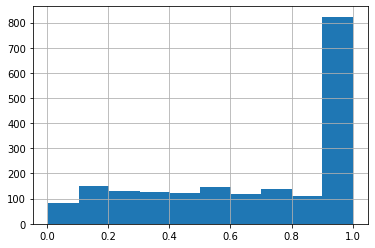

In [21]:
#df_productivity["percentFarmGateIncomes"].hist()

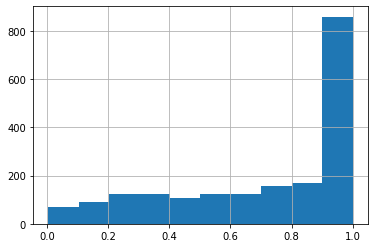

In [22]:
#df_productivity["percentSoldProduction"].hist()

# Economies of scale

In [23]:
# Group by zone (district)
def getProductionSoldVolume_UA_Zone(df_productivity):
    df_production = df_productivity[np.append(_MULTIINDEX_, ["soldProduction"])]
    df_production_zone = df_production.groupby(["NOMBREDD", "NOMBREPV", "NOMBREDI"])["soldProduction"].apply(np.sum).reset_index().rename(columns={"soldProduction": "volumeOfDistrict"})
    return pd.merge(df_production, df_production_zone, how="left", on=["NOMBREDD", "NOMBREPV", "NOMBREDI"], suffixes=("", "_y"))[np.append(_MULTIINDEX_, "volumeOfDistrict")]

In [24]:
#getProductionSoldVolume_UA_Zone(df_productivity)

In [25]:
df_economies_of_scale = getProductionSoldVolume_UA_Zone(df_productivity)

In [26]:
len(df_economies_of_scale)

1949

In [27]:
df_economies_of_scale.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'volumeOfDistrict'],
      dtype='object')

# Associativity

In [28]:
# Sí instead of Si value (difference of 2019 ENA)
def getAsociativity_UA(df, cropName):
    df["associativity"] = df["P801"].astype("category").cat.rename_categories({"No": 0, "Sí": 1})
    df_new = df[df["crop"] == cropName].groupby(_MULTIINDEX_)["associativity"].unique().apply(list).apply(np.sum).reset_index().rename(columns={"associativity": "associative"})
    return df_new

In [29]:
df_associativity = getAsociativity_UA(df, _CROPNAME_)

In [31]:
#df["associativity"].value_counts()

0    158789
1     14285
Name: associativity, dtype: int64

In [32]:
len(df_associativity)

4614

In [33]:
df_associativity.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'associative'],
      dtype='object')

# Information indices

In [132]:
variables = [{"newVariable": {"name": "P707", "n": 8, "k": 1}, "oldVariables": [{"name": "P707", "n": 8, "k": 1}]}, {"newVariable": {"name": "P708and712", "n": 13, "k": 1}, "oldVariables": [{"name": "P708", "n": 8, "k": 8}, {"name": "P712", "n": 9, "k": 1}]}, {"newVariable": {"name": "P709", "n": 9, "k": 1}, "oldVariables": [{"name": "P709", "n": 9, "k": 8}]}, {"newVariable": {"name": "P710", "n": 10, "k": 1}, "oldVariables": [{"name": "P710", "n": 10, "k": 1}]}]
options = {"P707": [{"value": "Sí", "includes": []}], "P708and712": [{"n": 1, "value": "Ministerio de Agricultura y Riego", "includes": ["P708_1", "P712_1"]}, {"n": 2, "value": "Agencia Agraria", "includes": ["P712_2"]}, {"n": 3, "value": "Instituto Nacional de Innovación Agraria (INIA)", "includes": ["P712_3"]}, {"n": 4, "value": "Servicio Nacional de Sanidad Agraria (SENASA)", "includes": ["P712_4"]}, {"n": 5, "value": "Instituto Nacional de Defensa Civil (INDECI)", "includes": ["P712_6"]}, {"n": 6, "value": "Servicio Nacional de Meteorología e Higrología (SENAMHI)", "includes": ["P712_8"]}, {"n": 7, "value": "Gobierno Regional", "includes": ["P708_2"]}, {"n": 8, "value": "Gobierno Local", "includes": ["P708_3"]}, {"n": 9, "value": "Organismo No Gubernamental (ONG)", "includes": ["P708_4", "P712_5"]}, {"n": 10, "value": "Empresa Privada", "includes": ["P708_5", "P712_7"]}, {"n": 11, "value": "Asociación de productores/as", "includes": ["P708_6"]}, {"n": 12, "value": "Comerciante, productor/a, amigo/a", "includes": ["P708_7"]}, {"n": 13, "value": "Otro", "includes": ["P708_8", "P712_9"]}], "P709": [{"n": 1, "value": "Radio", "includes": ["P709_1"]}, {"n": 2, "value": "Televisión", "includes": ["P709_2"]}, {"n": 3, "value": "Teléfono", "includes": ["P709_3"]}, {"n": 4, "value": "Diarios", "includes": ["P709_4"]}, {"n": 5, "value": "Folletos", "includes": ["P709_5"]}, {"n": 6, "value": "Internet", "includes": ["P709_6"]}, {"n": 7, "value": "Talleres", "includes": ["P709_7"]}, {"n": 8, "value": "Comunicación verbal", "includes": ["P709_8"]}, {"n": 9, "value": "Otro", "includes": ["P709_9"]}], "P710": [{"n": 1, "value": "Información agroclimática", "includes": ["P710_1"]}, {"n": 2, "value": "Manejo de enfermedades y plagas", "includes": ["P710_2"]}, {"n": 3, "value": "Precio de insumos agropecuarios", "includes": ["P710_3"]}, {"n": 4, "value": "Precio de venta (chacra, mayorista, minorista)", "includes": ["P710_4"]}, {"n": 5, "value": "Técnica de manejo de cultivos y crianza", "includes": ["P710_5"]}, {"n": 6, "value": "Técnica de manejo de semilla", "includes": ["P710_6"]}, {"n": 7, "value": "Uso de abonos y fertilizantes", "includes": ["P710_7"]}, {"n": 8, "value": "Técnicas y sistema de riego", "includes": ["P710_8"]}, {"n": 9, "value": "Análisis de suelos", "includes": ["P710_9"]}, {"n": 10, "value": "Otro", "includes": ["P710_10"]}]}

In [133]:
def getDfInfo(df):
    index_inf_type = [i for i in range(len(df.columns)) if "707" in df.columns[i]]
    index_infsource_who = [i for i in range(len(df.columns)) if "708" in df.columns[i]]
    index_infsource_who_2 = [i for i in range(len(df.columns)) if "712" in df.columns[i]]
    index_infsource_media = [i for i in range(len(df.columns)) if "709" in df.columns[i]]
    index_infsource_needs = [i for i in range(len(df.columns)) if "710" in df.columns[i]]

    inf_type = df.columns[index_inf_type]
    infsource_who = df.columns[index_infsource_who]
    infsource_who_2 = df.columns[index_infsource_who_2]
    infsource_media = df.columns[index_infsource_media]
    infsource_needs = df.columns[index_infsource_needs]

    selected_columns = np.concatenate((_MULTIINDEX_, ["crop"], inf_type, infsource_who, infsource_who_2, infsource_media, infsource_needs), axis=0)

    df_info = df[selected_columns]
    return df_info

In [134]:
def getOldData(df):
    oldData = {}
    # "P707_1": [0, 1], "P707_2": [1, 0]
    for variable in variables:
        newName = variable["newVariable"]["name"]
        N = variable["newVariable"]["n"] + 1
        K = variable["newVariable"]["k"] + 1
        oldVariables = variable["oldVariables"]
        option = options[newName]
        # print("==========", option)
        for x in oldVariables:
            # print("old variable", x)
            oName = x["name"]
            oK = x["k"] + 1
            oN = x["n"] + 1
            for o_n in range(1, oN):
                oVariable = oName + "_%s" % o_n
                cols = []
                # print("old variable", oVariable)
                if x["k"] > 1:
                    for o_k in range(1, oK):
                        okVariable = oName + "_%s" % o_k + "_%s" % o_n
                        cols = np.append(cols, okVariable)
                        # print("--------*", okVariable)
                    # print(len(cols))
                    prev = np.where(df[cols].fillna(0).replace({"Pase": 0}) != 0, 1, 0)
                    noreshape = np.where(np.sum(prev, axis = 1) >= 1, 1, 0)
                    oldData[oVariable] = noreshape.reshape((len(noreshape),))
                else:
                    cols = np.append(cols, oVariable)
                    # print("--------", oVariable)
                    # print(len(cols))
                    prev = np.where(df[cols].fillna(0).replace({"Pase": 0}) != 0, 1, 0)
                    noreshape = np.where(prev >= 1, 1, 0)
                    oldData[oVariable] = noreshape.reshape((len(noreshape),))

    return pd.DataFrame(data=oldData)

In [135]:
def getNewData(df, df_oldData):
    newData = {}
    for variable in variables:
        newName = variable["newVariable"]["name"]
        N = variable["newVariable"]["n"] + 1
        K = variable["newVariable"]["k"] + 1
        oldVariables = variable["oldVariables"]
        option = options[newName]
        # print("==========", option)
        for oldVariable in option:
            if len(option) > 1:
                n = oldVariable["n"]
                value = oldVariable["value"]
                oldVarIncludes = oldVariable["includes"]
                newVar = newName + "_%s" % n
                noreshape = np.where(np.sum(df_oldData[oldVarIncludes], axis=1) >= 1, 1, 0)
                newData[newVar] = noreshape.reshape((len(noreshape),))
                # print("====== new Data %s" % newVar, oldVarIncludes)

            else:
                for n in range(1, N):
                    newVar = newName + "_%s" % n
                    noreshape = (df[newVar] == "Sí").astype(int)
                    newData[newVar] = noreshape
                    # print("NEW: ", newVar)
    
            # print(oldVariable)
    return pd.DataFrame(data=newData)

In [136]:
def getDfInformation(df):
    df_oldData = getOldData(df)
    df_newData = getNewData(df, df_oldData)
    return pd.concat([df[np.append(_MULTIINDEX_, "crop")], df_newData], axis=1) 

In [137]:
df_info = getDfInfo(df)

In [138]:
df_info["P707_1"].value_counts()

Sí    115045
No     60713
Name: P707_1, dtype: int64

In [139]:
len(df_info.columns), len(df_info)

(170, 175758)

In [140]:
df_info02 = getDfInformation(df_info)

In [141]:
df_info02.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'crop', 'P707_1', 'P707_2', 'P707_3', 'P707_4', 'P707_5', 'P707_6',
       'P707_7', 'P707_8', 'P708and712_1', 'P708and712_2', 'P708and712_3',
       'P708and712_4', 'P708and712_5', 'P708and712_6', 'P708and712_7',
       'P708and712_8', 'P708and712_9', 'P708and712_10', 'P708and712_11',
       'P708and712_12', 'P708and712_13', 'P709_1', 'P709_2', 'P709_3',
       'P709_4', 'P709_5', 'P709_6', 'P709_7', 'P709_8', 'P709_9', 'P710_1',
       'P710_2', 'P710_3', 'P710_4', 'P710_5', 'P710_6', 'P710_7', 'P710_8',
       'P710_9', 'P710_10'],
      dtype='object')

In [142]:
len(df_info02.columns)

47

In [143]:
df_info02["P707_1"].value_counts()

1    115045
0     60713
Name: P707_1, dtype: int64

In [144]:
newNameColumns={"P707_1": "INFORMATION_1", "P707_2": "INFORMATION_2", "P707_3": "INFORMATION_3", "P707_4": "INFORMATION_4", "P707_5": "INFORMATION_5", "P707_6": "INFORMATION_6", "P707_7": "INFORMATION_7", "P707_8": "INFORMATION_8", "P707_NAN": "INFORMATION_NAN", "P708and712_1": "INSTITUCION_1", "P708and712_2": "INSTITUCION_2", "P708and712_3": "INSTITUCION_3", "P708and712_4": "INSTITUCION_4", "P708and712_5": "INSTITUCION_5", "P708and712_6": "INSTITUCION_6", "P708and712_7": "INSTITUCION_7", "P708and712_8": "INSTITUCION_8", "P708and712_9": "INSTITUCION_9", "P708and712_10": "INSTITUCION_10", "P708and712_11": "INSTITUCION_11", "P708and712_12": "INSTITUCION_12", "P708and712_13": "INSTITUCION_13", "P708and712_NAN": "INSTITUCION_NAN", "P709_1": "MEDIO_1", "P709_2": "MEDIO_2", "P709_3": "MEDIO_3", "P709_4": "MEDIO_4", "P709_5": "MEDIO_5", "P709_6": "MEDIO_6", "P709_7": "MEDIO_7", "P709_8": "MEDIO_8", "P709_9": "MEDIO_9", "P709_NAN": "MEDIO_NAN", "P710_1": "INFO_REQUERIDA_1", "P710_2": "INFO_REQUERIDA_2", "P710_3": "INFO_REQUERIDA_3", "P710_4": "INFO_REQUERIDA_4", "P710_5": "INFO_REQUERIDA_5", "P710_6": "INFO_REQUERIDA_6", "P710_7": "INFO_REQUERIDA_7", "P710_8": "INFO_REQUERIDA_8", "P710_9": "INFO_REQUERIDA_9", "P710_10": "INFO_REQUERIDA_10", "P710_NAN": "INFO_REQUERIDA_NAN"}

In [145]:
df_info_newcolumns = df_info02.rename(columns=newNameColumns)

In [146]:
df_info_newcolumns.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'crop', 'INFORMATION_1', 'INFORMATION_2', 'INFORMATION_3',
       'INFORMATION_4', 'INFORMATION_5', 'INFORMATION_6', 'INFORMATION_7',
       'INFORMATION_8', 'INSTITUCION_1', 'INSTITUCION_2', 'INSTITUCION_3',
       'INSTITUCION_4', 'INSTITUCION_5', 'INSTITUCION_6', 'INSTITUCION_7',
       'INSTITUCION_8', 'INSTITUCION_9', 'INSTITUCION_10', 'INSTITUCION_11',
       'INSTITUCION_12', 'INSTITUCION_13', 'MEDIO_1', 'MEDIO_2', 'MEDIO_3',
       'MEDIO_4', 'MEDIO_5', 'MEDIO_6', 'MEDIO_7', 'MEDIO_8', 'MEDIO_9',
       'INFO_REQUERIDA_1', 'INFO_REQUERIDA_2', 'INFO_REQUERIDA_3',
       'INFO_REQUERIDA_4', 'INFO_REQUERIDA_5', 'INFO_REQUERIDA_6',
       'INFO_REQUERIDA_7', 'INFO_REQUERIDA_8', 'INFO_REQUERIDA_9',
       'INFO_REQUERIDA_10'],
      dtype='object')

In [147]:
# Adding NAN variables
base = ["INFORMATION", "INSTITUTION", "MEDIO", "INFO_REQUERIDA"]

columns = {"INFORMATION": ["INFORMATION_1", "INFORMATION_2", "INFORMATION_3", "INFORMATION_4", "INFORMATION_5", "INFORMATION_6", "INFORMATION_7", "INFORMATION_8"], "INSTITUTION": ["INSTITUCION_1", "INSTITUCION_2", "INSTITUCION_3", "INSTITUCION_4", "INSTITUCION_5", "INSTITUCION_6", "INSTITUCION_7", "INSTITUCION_8", "INSTITUCION_9", "INSTITUCION_10", "INSTITUCION_11", "INSTITUCION_12", "INSTITUCION_13"], "MEDIO": ["MEDIO_1", "MEDIO_2", "MEDIO_3", "MEDIO_4", "MEDIO_5", "MEDIO_6", "MEDIO_7", "MEDIO_8", "MEDIO_9"], "INFO_REQUERIDA": ["INFO_REQUERIDA_1", "INFO_REQUERIDA_2", "INFO_REQUERIDA_3", "INFO_REQUERIDA_4", "INFO_REQUERIDA_5", "INFO_REQUERIDA_6", "INFO_REQUERIDA_7", "INFO_REQUERIDA_8", "INFO_REQUERIDA_9", "INFO_REQUERIDA_10"]}

for name in base:
    df_info_newcolumns["%s_NAN" % name] = (df_info_newcolumns[columns[name]].sum(axis=1) == 0)*1

In [148]:
df_info_newcolumns.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'crop', 'INFORMATION_1', 'INFORMATION_2', 'INFORMATION_3',
       'INFORMATION_4', 'INFORMATION_5', 'INFORMATION_6', 'INFORMATION_7',
       'INFORMATION_8', 'INSTITUCION_1', 'INSTITUCION_2', 'INSTITUCION_3',
       'INSTITUCION_4', 'INSTITUCION_5', 'INSTITUCION_6', 'INSTITUCION_7',
       'INSTITUCION_8', 'INSTITUCION_9', 'INSTITUCION_10', 'INSTITUCION_11',
       'INSTITUCION_12', 'INSTITUCION_13', 'MEDIO_1', 'MEDIO_2', 'MEDIO_3',
       'MEDIO_4', 'MEDIO_5', 'MEDIO_6', 'MEDIO_7', 'MEDIO_8', 'MEDIO_9',
       'INFO_REQUERIDA_1', 'INFO_REQUERIDA_2', 'INFO_REQUERIDA_3',
       'INFO_REQUERIDA_4', 'INFO_REQUERIDA_5', 'INFO_REQUERIDA_6',
       'INFO_REQUERIDA_7', 'INFO_REQUERIDA_8', 'INFO_REQUERIDA_9',
       'INFO_REQUERIDA_10', 'INFORMATION_NAN', 'INSTITUTION_NAN', 'MEDIO_NAN',
       'INFO_REQUERIDA_NAN'],
      dtype='object')

In [149]:
def getVariablesForInformationIndex(df):
    df["INFO_PRECIO"] = df["INFORMATION_1"]
    df["INFO_METEREOLOGICA"] = df["INFORMATION_5"]
    df["INFO_CALIDAD_VECINO_AMIGO"] = df["INSTITUCION_12"]
    institutions = ["INSTITUCION_1", "INSTITUCION_2", "INSTITUCION_3", "INSTITUCION_4", "INSTITUCION_5", "INSTITUCION_6", "INSTITUCION_7", "INSTITUCION_8", "INSTITUCION_9", "INSTITUCION_10", "INSTITUCION_11", "INSTITUCION_13"]
    df["INFO_CALIDAD_INSTITUCION"] = (df[institutions].sum(axis=1) > 0)*1

In [150]:
getVariablesForInformationIndex(df_info_newcolumns)

In [151]:
df_info_newcolumns["INFO_CALIDAD_INSTITUCION"].value_counts()

0    133559
1     42199
Name: INFO_CALIDAD_INSTITUCION, dtype: int64

In [152]:
def getInformationIndex(df):
    df["INDEX_PRECIO_INFORMAL"] = df["INFO_PRECIO"] * df["INFO_CALIDAD_VECINO_AMIGO"]
    df["INDEX_PRECIO_FORMAL"] = df["INFO_PRECIO"] * df["INFO_CALIDAD_INSTITUCION"]
    df["INDEX_PRECIO_NAN"] = (df[["INDEX_PRECIO_INFORMAL", "INDEX_PRECIO_FORMAL"]].sum(axis=1) == 0) * 1

    df["INDEX_METEREOLOGICA_INFORMAL"] = df["INFO_METEREOLOGICA"] * df["INFO_CALIDAD_VECINO_AMIGO"]
    df["INDEX_METEREOLOGICA_FORMAL"] = df["INFO_METEREOLOGICA"] * df["INFO_CALIDAD_INSTITUCION"]
    df["INDEX_METEREOLOGICA_NAN"] = (df[["INDEX_METEREOLOGICA_INFORMAL", "INDEX_METEREOLOGICA_FORMAL"]].sum(axis=1) == 0) * 1
    
    df["INDEX_NAN_INFORMAL"] = (df[["INDEX_PRECIO_INFORMAL", "INDEX_METEREOLOGICA_INFORMAL"]].sum(axis=1) == 0) * 1
    df["INDEX_NAN_FORMAL"] = (df[["INDEX_PRECIO_FORMAL", "INDEX_METEREOLOGICA_FORMAL"]].sum(axis=1) == 0) * 1

    df["INDEX_NAN_NAN"] = (df[["INDEX_PRECIO_INFORMAL", "INDEX_PRECIO_FORMAL", "INDEX_METEREOLOGICA_INFORMAL", "INDEX_METEREOLOGICA_FORMAL"]].sum(axis=1) == 0) * 1

In [153]:
getInformationIndex(df_info_newcolumns)

In [154]:
df_info_newcolumns.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'crop', 'INFORMATION_1', 'INFORMATION_2', 'INFORMATION_3',
       'INFORMATION_4', 'INFORMATION_5', 'INFORMATION_6', 'INFORMATION_7',
       'INFORMATION_8', 'INSTITUCION_1', 'INSTITUCION_2', 'INSTITUCION_3',
       'INSTITUCION_4', 'INSTITUCION_5', 'INSTITUCION_6', 'INSTITUCION_7',
       'INSTITUCION_8', 'INSTITUCION_9', 'INSTITUCION_10', 'INSTITUCION_11',
       'INSTITUCION_12', 'INSTITUCION_13', 'MEDIO_1', 'MEDIO_2', 'MEDIO_3',
       'MEDIO_4', 'MEDIO_5', 'MEDIO_6', 'MEDIO_7', 'MEDIO_8', 'MEDIO_9',
       'INFO_REQUERIDA_1', 'INFO_REQUERIDA_2', 'INFO_REQUERIDA_3',
       'INFO_REQUERIDA_4', 'INFO_REQUERIDA_5', 'INFO_REQUERIDA_6',
       'INFO_REQUERIDA_7', 'INFO_REQUERIDA_8', 'INFO_REQUERIDA_9',
       'INFO_REQUERIDA_10', 'INFORMATION_NAN', 'INSTITUTION_NAN', 'MEDIO_NAN',
       'INFO_REQUERIDA_NAN', 'INFO_PRECIO', 'INFO_METEREOLOGICA',
       'INFO_CALIDAD_VECINO_AMIGO', 'INFO_CALIDAD_INSTITUCION'

In [155]:
df_information_indices = df_info_newcolumns.rename(columns={"INDEX_PRECIO_INFORMAL": "informalPriceInformation", "INDEX_PRECIO_FORMAL": "formalPriceInformation", "INDEX_METEREOLOGICA_INFORMAL": "informalMetereologicalInformation", "INDEX_METEREOLOGICA_FORMAL": "formalMetereologicalInformation"})

In [156]:
len(df_information_indices)

175758

In [157]:
def getVariableColum_UA(df, cropName, variable):
    df_crop = df[df["crop"] == cropName]
    # print(cropName)
    variableObs = df_crop.groupby(_MULTIINDEX_)[variable].unique().apply(lambda x: x[0]).reset_index()
    print(variable, len(variableObs))
    return variableObs

indexVar = ["INDEX_NAN_NAN", "INDEX_NAN_INFORMAL", "INDEX_NAN_FORMAL", "INDEX_PRECIO_NAN", "INDEX_PRECIO_INFORMAL", "INDEX_PRECIO_FORMAL", "INDEX_METEREOLOGICA_NAN", "INDEX_METEREOLOGICA_INFORMAL", "INDEX_METEREOLOGICA_FORMAL"]

In [158]:
# "INDEX_NAN_NAN", "INDEX_NAN_INFORMAL", "INDEX_NAN_FORMAL",
# "INDEX_PRECIO_NAN", "INDEX_PRECIO_INFORMAL", "INDEX_PRECIO_FORMAL",
# "INDEX_CANTIDAD_NAN", "INDEX_CANTIDAD_INFORMAL", "INDEX_CANTIDAD_FORMAL",
# "INDEX_METEREOLOGICA_NAN", "INDEX_METEREOLOGICA_INFORMAL", "INDEX_METEREOLOGICA_FORMAL"
# df_info_whitepotato_newcolumns
def filteringInformationIndex_UA(df, cropName):
    _00 = getVariableColum_UA(df, cropName, "INDEX_NAN_NAN")
    _10 = getVariableColum_UA(df, cropName, "INDEX_PRECIO_NAN")
    _20 = getVariableColum_UA(df, cropName, "INDEX_METEREOLOGICA_NAN")
    _01 = getVariableColum_UA(df, cropName, "INDEX_NAN_INFORMAL")
    _11 = getVariableColum_UA(df, cropName, "INDEX_PRECIO_INFORMAL")
    _21 = getVariableColum_UA(df, cropName, "INDEX_METEREOLOGICA_INFORMAL")
    _02 = getVariableColum_UA(df, cropName, "INDEX_NAN_FORMAL")
    _12 = getVariableColum_UA(df, cropName, "INDEX_PRECIO_FORMAL")
    _22 = getVariableColum_UA(df, cropName, "INDEX_METEREOLOGICA_FORMAL")
    return pd.concat([_00, _10["INDEX_PRECIO_NAN"], _20["INDEX_METEREOLOGICA_NAN"], _01["INDEX_NAN_INFORMAL"], _11["INDEX_PRECIO_INFORMAL"], _21["INDEX_METEREOLOGICA_INFORMAL"], _02["INDEX_NAN_FORMAL"], _12["INDEX_PRECIO_FORMAL"], _22["INDEX_METEREOLOGICA_FORMAL"]], axis=1, sort=False)

In [159]:
df_information = filteringInformationIndex_UA(df_info_newcolumns, _CROPNAME_)

INDEX_NAN_NAN 4614
INDEX_PRECIO_NAN 4614
INDEX_METEREOLOGICA_NAN 4614
INDEX_NAN_INFORMAL 4614
INDEX_PRECIO_INFORMAL 4614
INDEX_METEREOLOGICA_INFORMAL 4614
INDEX_NAN_FORMAL 4614
INDEX_PRECIO_FORMAL 4614
INDEX_METEREOLOGICA_FORMAL 4614


In [160]:
df_information.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'INDEX_NAN_NAN', 'INDEX_PRECIO_NAN', 'INDEX_METEREOLOGICA_NAN',
       'INDEX_NAN_INFORMAL', 'INDEX_PRECIO_INFORMAL',
       'INDEX_METEREOLOGICA_INFORMAL', 'INDEX_NAN_FORMAL',
       'INDEX_PRECIO_FORMAL', 'INDEX_METEREOLOGICA_FORMAL'],
      dtype='object')

In [161]:
columnsSelected = ["informalPriceInformation", "formalPriceInformation", "informalMetereologicalInformation", "formalMetereologicalInformation"]
df_information_indices = df_information.rename(columns={"INDEX_PRECIO_INFORMAL": "informalPriceInformation", "INDEX_PRECIO_FORMAL": "formalPriceInformation", "INDEX_METEREOLOGICA_INFORMAL": "informalMetereologicalInformation", "INDEX_METEREOLOGICA_FORMAL": "formalMetereologicalInformation"})[np.append(_MULTIINDEX_, columnsSelected)]

In [162]:
len(df_information_indices)

4614

In [163]:
df_information_indices.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'informalPriceInformation', 'formalPriceInformation',
       'informalMetereologicalInformation', 'formalMetereologicalInformation'],
      dtype='object')

# Market size

In [164]:
def getMarketSizeVariables(df):
    df["MARKET_LOCAL"] = (df["P223_1"] == "Mercado local (feria local, centro de acopio local)?").astype(int)
    df["MARKET_REGIONAL"] = (df["P223_2"] == "Mercado regional (feria regional, centro de acopio regional)?").astype(int)
    df["MARKET_LIMA"] = (df["P223_5"] == "Mercados de Lima?").astype(int)
    df["MARKET_AGROINDUSTRY"] = (df["P223_4"] == "Agroindustria?").astype(int)
    df["MARKET_EXPORT"] = (df["P223_3"] == "Mercado exterior?").astype(int)
    df["MARKET_NAN"] = (df["P223_6"] == "NO SABE").astype(int)

In [165]:
def getMarketSizeDummies_UA(df, cropName, indices):
    getMarketSizeVariables(df)
    df_1 = df[df["crop"] == cropName].groupby(indices)["MARKET_LOCAL"].unique().apply(lambda x: x[0]).reset_index()
    df_2 = df[df["crop"] == cropName].groupby(indices)["MARKET_REGIONAL"].unique().apply(lambda x: x[0]).reset_index()
    df_3 = df[df["crop"] == cropName].groupby(indices)["MARKET_LIMA"].unique().apply(lambda x: x[0]).reset_index()
    df_4 = df[df["crop"] == cropName].groupby(indices)["MARKET_AGROINDUSTRY"].unique().apply(lambda x: x[0]).reset_index()
    df_5 = df[df["crop"] == cropName].groupby(indices)["MARKET_EXPORT"].unique().apply(lambda x: x[0]).reset_index()
    df_6 = df[df["crop"] == cropName].groupby(indices)["MARKET_NAN"].unique().apply(lambda x: x[0]).reset_index()
    return pd.concat([df_1, df_2["MARKET_REGIONAL"], df_3["MARKET_LIMA"], df_4["MARKET_AGROINDUSTRY"], df_5["MARKET_EXPORT"], df_6["MARKET_NAN"]], axis=1, sort=False)

In [166]:
def getLastMarketSize(x):
    x = list(filter(lambda x : x != "MARKET_NAN", x))
    if len(x):
        last_one = x[-1]
        if last_one == "MARKET_LOCAL":
            val = "Local market"
        elif last_one == "MARKET_REGIONAL":
            val = "Regional market"
        elif last_one == "MARKET_LIMA":
            val = "Lima markets"
        elif last_one == "MARKET_AGROINDUSTRY":
            val = "Agroindustry"
        elif last_one == "MARKET_EXPORT":
            val = "Outside market"
        else:
            val = None
        return val
    else:
        return None

In [167]:
_MARKET_SIZE_ = ["MARKET_LOCAL", "MARKET_REGIONAL", "MARKET_LIMA", "MARKET_AGROINDUSTRY", "MARKET_EXPORT", "MARKET_NAN"]

In [168]:
# Number of market size selected options
def getMoreMarketSizeVariables_UA(df):
    df["MARKETS"] = df[_MARKET_SIZE_].apply(lambda x: x.index[x.astype(bool)].tolist(), axis=1)
    df["MARKETS_QTY"] = df["MARKETS"].apply(lambda x: len(x))
    df["LAST_MARKET_SIZE"] = df["MARKETS"].apply(getLastMarketSize)

In [169]:
df_marketsize = getMarketSizeDummies_UA(df, _CROPNAME_, _MULTIINDEX_)
getMoreMarketSizeVariables_UA(df_marketsize)
df_marketSize = df_marketsize.rename(columns={"MARKET_LOCAL": "localMarket", "MARKET_REGIONAL": "regionalMarket", "MARKET_LIMA": "limaMarket", "MARKET_AGROINDUSTRY": "agroindustryMarket", "MARKET_EXPORT": "exportMarket", "LAST_MARKET_SIZE": "marketSize"})

In [170]:
len(df_marketsize)

4614

In [171]:
df_marketSize.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'localMarket', 'regionalMarket', 'limaMarket', 'agroindustryMarket',
       'exportMarket', 'MARKET_NAN', 'MARKETS', 'MARKETS_QTY', 'marketSize'],
      dtype='object')

In [172]:
df_marketSize["marketSize"].value_counts()

Local market       1521
Regional market     390
Lima markets        158
Outside market        2
Agroindustry          1
Name: marketSize, dtype: int64

# Market channel Directedness

In [173]:
_DIRECT_ACCESS_TO_CONSUMERS_ = ["COLLECTOR", "WHOLESALER", "RETAILER", "ASOCIATION_COOPERATIVE", "ENTERPRISE_AGROINDUSTRY", "CONSUMER", "ATC_NAN"]

In [174]:
def getDirectAccessVariables(df):
    df["COLLECTOR"] = (df["P222_1"] == "Acopiador").astype(int)
    df["WHOLESALER"] = (df["P222_2"] == "Comerciante mayorista").astype(int)
    df["RETAILER"] = (df["P222_3"] == "Comerciante minorista").astype(int)
    df["ASOCIATION_COOPERATIVE"] = (df["P222_4"] == "Asociación / cooperativa").astype(int)
    df["ENTERPRISE_AGROINDUSTRY"] = (df["P222_5"] == "Empresa / agroindustria").astype(int)
    df["CONSUMER"] = (df["P222_6"] == "Consumidor Final").astype(int)
    df["ATC_NAN"] = (df["P222_7"] == "NO SABE").astype(int)
    
def getDirectAccessDummies_UA(df, cropName, indices):
    getDirectAccessVariables(df)
    df_1 = df[df["crop"] == cropName].groupby(indices)["COLLECTOR"].unique().apply(lambda x: x[0]).reset_index()
    df_2 = df[df["crop"] == cropName].groupby(indices)["WHOLESALER"].unique().apply(lambda x: x[0]).reset_index()
    df_3 = df[df["crop"] == cropName].groupby(indices)["RETAILER"].unique().apply(lambda x: x[0]).reset_index()
    df_4 = df[df["crop"] == cropName].groupby(indices)["ASOCIATION_COOPERATIVE"].unique().apply(lambda x: x[0]).reset_index()
    df_5 = df[df["crop"] == cropName].groupby(indices)["ENTERPRISE_AGROINDUSTRY"].unique().apply(lambda x: x[0]).reset_index()
    df_6 = df[df["crop"] == cropName].groupby(indices)["CONSUMER"].unique().apply(lambda x: x[0]).reset_index()
    df_7 = df[df["crop"] == cropName].groupby(indices)["ATC_NAN"].unique().apply(lambda x: x[0]).reset_index()
    return pd.concat([df_1, df_2["WHOLESALER"], df_3["RETAILER"], df_4["ASOCIATION_COOPERATIVE"], df_5["ENTERPRISE_AGROINDUSTRY"], df_6["CONSUMER"], df_7["ATC_NAN"]], axis=1, sort=False)

In [175]:
def getDirectAccessSize(x):
    x = list(filter(lambda x : x != "ATC_NAN", x))
    if len(x):
        last_one = x[-1]
        if last_one == "COLLECTOR":
            val = "Collector"
        elif last_one == "WHOLESALER":
            val = "Wholesaler"
        elif last_one == "RETAILER":
            val = "Retailer"
        elif last_one == "ASOCIATION_COOPERATIVE":
            val = "Association / Cooperative"
        elif last_one == "ENTERPRISE_AGROINDUSTRY":
            val = "Company / Agribusiness"
        elif last_one == "CONSUMER":
            val = "Final consumer"
        else:
            val = None
        return val
    else:
        return None

def getMoreDirectAccessVariables_UA(df):
    df["DIRECT_ACCESS"] = df[_DIRECT_ACCESS_TO_CONSUMERS_].apply(lambda x: x.index[x.astype(bool)].tolist(), axis=1)
    df["DIRECT_ACCESS_QTY"] = df["DIRECT_ACCESS"].apply(lambda x: len(x))
    df["LAST_DIRECT_ACCESS"] = df["DIRECT_ACCESS"].apply(getDirectAccessSize)

In [176]:
df_04 = getDirectAccessDummies_UA(df, _CROPNAME_, _MULTIINDEX_)
getMoreDirectAccessVariables_UA(df_04)

In [177]:
df_marketChannelDirectedness = df_04.rename(columns={"COLLECTOR": "collector", "WHOLESALER": "wholesaler", "RETAILER": "retailer", "ASOCIATION_COOPERATIVE": "cooperative", "ENTERPRISE_AGROINDUSTRY": "enterprise", "CONSUMER": "finalConsumer", "LAST_DIRECT_ACCESS": "marketChannelDirectedness"})
df_marketChannelDirectedness = df_marketChannelDirectedness[np.append(_MULTIINDEX_, ["collector", "wholesaler", "retailer", "enterprise", "finalConsumer", "marketChannelDirectedness"])]

In [178]:
len(df_marketChannelDirectedness)

4614

In [179]:
df_marketChannelDirectedness.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'collector', 'wholesaler', 'retailer', 'enterprise', 'finalConsumer',
       'marketChannelDirectedness'],
      dtype='object')

In [180]:
df_marketChannelDirectedness["marketChannelDirectedness"].value_counts()

Collector                 560
Wholesaler                550
Final consumer            507
Retailer                  453
Company / Agribusiness      2
Name: marketChannelDirectedness, dtype: int64

# Number of District's points of sale

In [181]:
df_points_of_sale = pd.read_csv(_PATH_ + "/" + "cenama/Capitulo_IV_NACIONAL.csv").rename(columns={"DEPARTAMENTO": "NOMBREDD", "PROVINCIA": "NOMBREPV", "DISTRITO": "NOMBREDI", "P39_1": "pointsOfSale"})

In [182]:
df_points_of_sale.columns

Index(['Unnamed: 0', 'ID', 'CCDD', 'NOMBREDD', 'CCPP', 'NOMBREPV', 'CCDI',
       'NOMBREDI', 'P29', 'P30_1', 'P30_2', 'P30_3', 'P30_4', 'P31_1', 'P31_2',
       'P32_1', 'P32_2', 'P32_3', 'P33', 'P33_Otro', 'P34', 'P34_Otro', 'P34A',
       'P35', 'P35_Otro', 'P36_1', 'P36_2', 'P36_3', 'P36A_1', 'P36A_2',
       'P36B_1', 'P36B_2', 'P37', 'P38', 'pointsOfSale', 'P39_2', 'P39_3',
       'P39_4', 'P39_5', 'P39_6', 'P39_7', 'P39_8', 'P39_9', 'P39_9_Otro',
       'P39_Total', 'P40_1', 'P40_1_TIEMPO', 'P40_2', 'P40_2_TIEMPO', 'P40_3',
       'P40_3_TIEMPO'],
      dtype='object')

In [183]:
s = ["NOMBREDD", "NOMBREPV", "NOMBREDI", "pointsOfSale"]
df_points_of_sale = df_points_of_sale[s]

In [184]:
df_points_of_sale = df_points_of_sale.groupby(["NOMBREDD", "NOMBREPV", "NOMBREDI"])["pointsOfSale"].apply(np.sum).reset_index()

In [185]:
df_points_of_sale

,NOMBREDD,NOMBREPV,NOMBREDI,pointsOfSale
0,AMAZONAS,BAGUA,ARAMANGO,5.0
1,AMAZONAS,BAGUA,BAGUA,5.0
2,AMAZONAS,BAGUA,IMAZA,4.0
3,AMAZONAS,BAGUA,LA PECA,90.0
4,AMAZONAS,BONGARA,JAZAN,43.0
...,...,...,...,...
632,ÁNCASH,SANTA,SAMANCO,2.0
633,ÁNCASH,SANTA,SANTA,30.0
634,ÁNCASH,SIHUAS,SIHUAS,11.0
635,ÁNCASH,YUNGAY,MANCOS,0.0


In [186]:
df_points_of_sale.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'pointsOfSale'], dtype='object')

# Model dataframe

In [187]:
df_model = mergeDataFrames([df_productivity, df_economies_of_scale, df_associativity, df_information_indices, df_marketSize, df_marketChannelDirectedness], _MULTIINDEX_)

In [188]:
df_model = mergeDataFrames([df_model, df_points_of_sale], ["NOMBREDD", "NOMBREPV", "NOMBREDI"])

In [189]:
len(df_model)

1949

In [190]:
df_model.columns

Index(['NOMBREDD', 'NOMBREPV', 'NOMBREDI', 'CONGLOMERADO', 'NSELUA', 'UA',
       'crop', 'production', 'totalProduction', 'percentProduction',
       'soldProduction', 'totalSoldProduction', 'percentSoldProduction',
       'farmGatePricePerKg', 'farmGateIncomes', 'totalFarmGateIncomes',
       'percentFarmGateIncomes', 'plantedArea', 'totalPlantedArea',
       'percentPlantedArea', 'yield', 'volumeOfDistrict', 'associative',
       'informalPriceInformation', 'formalPriceInformation',
       'informalMetereologicalInformation', 'formalMetereologicalInformation',
       'localMarket', 'regionalMarket', 'limaMarket', 'agroindustryMarket',
       'exportMarket', 'MARKET_NAN', 'MARKETS', 'MARKETS_QTY', 'marketSize',
       'collector', 'wholesaler', 'retailer', 'enterprise', 'finalConsumer',
       'marketChannelDirectedness', 'pointsOfSale'],
      dtype='object')

In [191]:
df_model.isnull().sum(axis=0)

NOMBREDD                                0
NOMBREPV                                0
NOMBREDI                                0
CONGLOMERADO                            0
NSELUA                                  0
UA                                      0
crop                                    0
production                              0
totalProduction                         0
percentProduction                       0
soldProduction                          0
totalSoldProduction                     0
percentSoldProduction                   0
farmGatePricePerKg                      0
farmGateIncomes                         0
totalFarmGateIncomes                    0
percentFarmGateIncomes                  0
plantedArea                             0
totalPlantedArea                        0
percentPlantedArea                      0
yield                                   0
volumeOfDistrict                        0
associative                            23
informalPriceInformation          

In [192]:
def removeRowsForMarketChannelDirectedness(df):
    values = ["Collector", "Retailer", "Wholesaler", "Final consumer"]
    return df[df["marketChannelDirectedness"].isin(values)]

In [193]:
def removeRowsForMarketSize(df):
    values = ["Local market", "Regional market", "Lima markets"]
    return df[df["marketSize"].isin(values)]

In [194]:
def removeAssociativeNullValues(df):
    return df[~df["associative"].isnull()]

In [195]:
def changeNanToZero(df, variable):
    df[df[variable].isnull()][variable] = 0

In [196]:
df_model_filtered = removeRowsForMarketChannelDirectedness(df_model)

In [197]:
df_model_filtered = removeRowsForMarketSize(df_model_filtered)

In [198]:
df_model_filtered = removeAssociativeNullValues(df_model_filtered)

In [199]:
changeNanToZero(df_model_filtered, "pointsOfSale")

<ipython-input-195-f52fa33eafae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df[variable].isnull()][variable] = 0


In [200]:
len(df_model_filtered)

1923

In [201]:
df_model_filtered.isnull().sum(axis=0)

NOMBREDD                                0
NOMBREPV                                0
NOMBREDI                                0
CONGLOMERADO                            0
NSELUA                                  0
UA                                      0
crop                                    0
production                              0
totalProduction                         0
percentProduction                       0
soldProduction                          0
totalSoldProduction                     0
percentSoldProduction                   0
farmGatePricePerKg                      0
farmGateIncomes                         0
totalFarmGateIncomes                    0
percentFarmGateIncomes                  0
plantedArea                             0
totalPlantedArea                        0
percentPlantedArea                      0
yield                                   0
volumeOfDistrict                        0
associative                             0
informalPriceInformation          

In [202]:
df_model_filtered["marketChannelDirectedness"].value_counts()

Collector         522
Wholesaler        520
Final consumer    458
Retailer          423
Name: marketChannelDirectedness, dtype: int64

In [203]:
df_model_filtered["marketSize"].value_counts()

Local market       1406
Regional market     365
Lima markets        152
Name: marketSize, dtype: int64

In [204]:
df_model_filtered["associative"].value_counts()

0.0    1825
1.0      98
Name: associative, dtype: int64

In [205]:
#df_model_filtered.to_csv("~/Desktop/DatosENA2019/2019_03PreModelDatabaseOfWhitePotato.csv")